In [ ]:
import pandas as pd

# 엑셀 파일 로드
file_path_train = "./archive/train_dataframes.xlsx"
file_path_test = "./archive/test_dataframes.xlsx"

# 엑셀 파일을 로드
xls_train = pd.ExcelFile(file_path_train)
xls_test = pd.ExcelFile(file_path_test)

# 모든 시트를 하나의 데이터프레임으로 병합
train_dfs = []
test_dfs = []

for sheet in xls_train.sheet_names:
    df_train = pd.read_excel(xls_train, sheet_name=sheet)
    df_test = pd.read_excel(xls_test, sheet_name=sheet)

    train_dfs.append(df_train)
    test_dfs.append(df_test)

# 병합된 데이터 저장
df_train_all = pd.concat(train_dfs, ignore_index=True)
df_test_all = pd.concat(test_dfs, ignore_index=True)

# CSV 파일로 저장
df_train_all.to_csv("train_data.csv", index=False)
df_test_all.to_csv("test_data.csv", index=False)

print("✅ CSV 변환 완료: train_data.csv, test_data.csv 저장됨")


In [94]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

# CSV 파일 로드
df_train_all = pd.read_csv("./archive/train_data.csv")
df_test_all = pd.read_csv("./archive/test_data.csv")

# 피처(X)와 타겟(y) 설정
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4", "dayOfWeek", "weekend", "holiday", "hourOfDay", "T2M_toc"]
X_train = df_train_all[features]
y_train = df_train_all["DEMAND"]
X_test = df_test_all[features]
y_test = df_test_all["DEMAND"]

# XGBoost 2.1.4에서는 DMatrix 사용이 안정적
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

# XGBoost 파라미터 설정
params = {
    "objective": "reg:squarederror",
    "learning_rate": 0.1,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "eval_metric": "rmse"
}

# 조기 종료 적용
evals = [(dtrain, "train"), (dtest, "validation")]

# 모델 학습
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,  # 트리 개수
    evals=evals,
    early_stopping_rounds=10,  # 조기 종료 적용
    verbose_eval=False
)

# 테스트 데이터 예측 및 평가
y_pred = model.predict(dtest)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # 🔹 squared=False 제거하고 np.sqrt() 사용

print(f"✅ Mean Absolute Error (MAE): {mae}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse}")


✅ Mean Absolute Error (MAE): 42.85922111907752
✅ Root Mean Squared Error (RMSE): 54.36260614043281


In [80]:
print(f"🔹 실제 전력 사용량 평균: {y_test.mean():.2f}")
print(f"🔹 실제 전력 사용량 표준편차: {y_test.std():.2f}")

mae_percentage = (42.86 / 1223.85) * 100
rmse_percentage = (54.36 / 1223.85) * 100

print(f"🔹 MAE 오차 비율: {mae_percentage:.2f}%")
print(f"🔹 RMSE 오차 비율: {rmse_percentage:.2f}%")


🔹 실제 전력 사용량 평균: 1223.85
🔹 실제 전력 사용량 표준편차: 187.98
🔹 MAE 오차 비율: 3.50%
🔹 RMSE 오차 비율: 4.44%


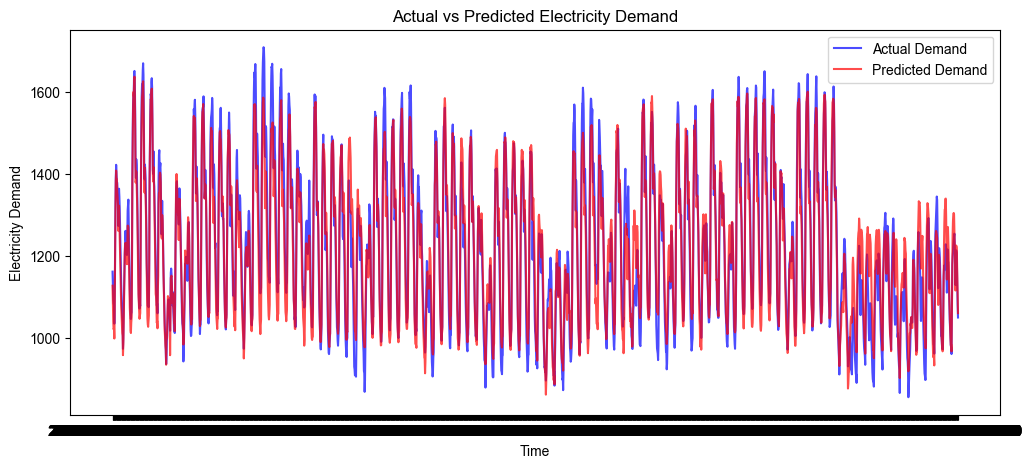

In [95]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 실제값과 예측값 비교

plt.figure(figsize=(12, 5))
plt.plot(df_test_all["datetime"], y_test, label="Actual Demand", color="blue", alpha=0.7)
plt.plot(df_test_all["datetime"], y_pred, label="Predicted Demand", color="red", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Electricity Demand")
plt.title("Actual vs Predicted Electricity Demand")
plt.legend()
plt.xticks()
plt.show()

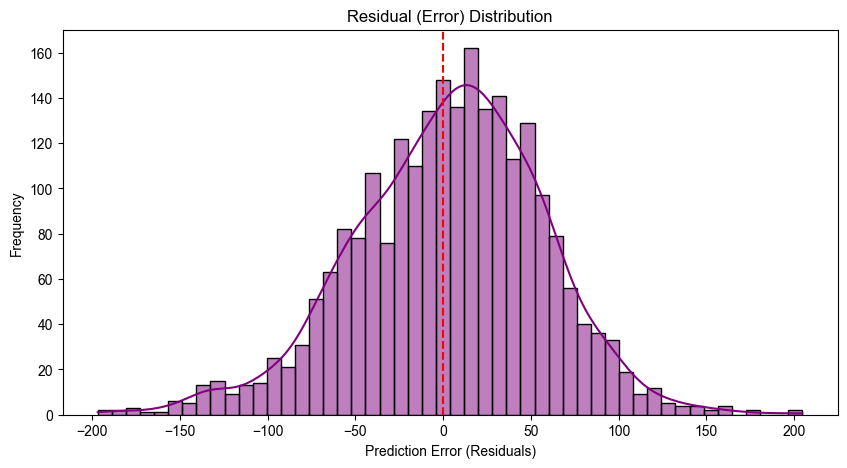

In [82]:
## 잔차 분석 (오차 히스토그램)

residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.axvline(0, color='red', linestyle="--")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Residual (Error) Distribution")
plt.show()

/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_11684/4017079178.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="coolwarm")


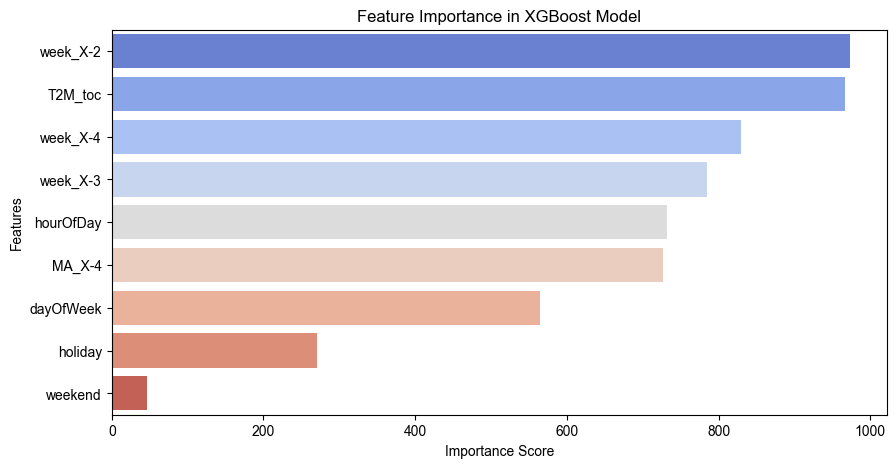

In [83]:
## 변수 중요도

importance = model.get_score(importance_type="weight")
importance_df = pd.DataFrame(list(importance.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.show()

/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_11684/3518382326.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_test_all["hourOfDay"], y=df_test_all["error"], palette="viridis")


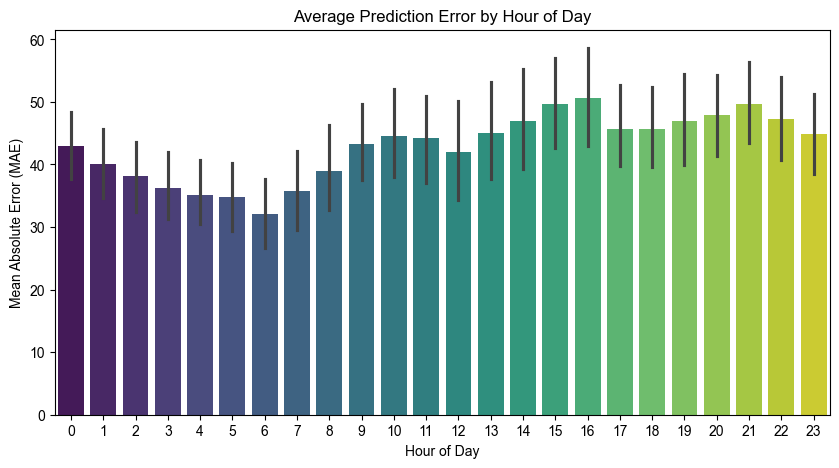

In [84]:
## 시간대별 평균 오차 분석

df_test_all["error"] = abs(y_test - y_pred)

plt.figure(figsize=(10, 5))
sns.barplot(x=df_test_all["hourOfDay"], y=df_test_all["error"], palette="viridis")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Average Prediction Error by Hour of Day")
plt.show()

🛑🛑🛑 성능 개선위해 🛑🛑🛑

(1) 시간대별 오차 분석 -> 피크 타임 (출퇴근시간) 변수 추가
(2) 계절 변수 추가 (여름철, 겨울철 전력 사용량 증가에 따름)
(3) 하이퍼파라미터 튜닝

In [96]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

# CSV 파일 로드
df_train_all = pd.read_csv("./archive/train_data.csv")
df_test_all = pd.read_csv("./archive/test_data.csv")

# 시간 변수를 datetime 형식으로 변환
df_train_all["datetime"] = pd.to_datetime(df_train_all["datetime"])
df_test_all["datetime"] = pd.to_datetime(df_test_all["datetime"])

#  (1) 피크 타임(출퇴근 시간, hourOfDay) 변수 추가
def peak_time(hour):
    return 1 if (6 <= hour <= 9) or (17 <= hour <= 20) else 0

df_train_all["peak_time"] = df_train_all["hourOfDay"].apply(peak_time)
df_test_all["peak_time"] = df_test_all["hourOfDay"].apply(peak_time)

#  (2) 계절 변수(season) 추가
df_train_all["season"] = df_train_all["datetime"].apply(lambda x: (x.month % 12 + 3) // 3)
df_test_all["season"] = df_test_all["datetime"].apply(lambda x: (x.month % 12 + 3) // 3)

#  (3) 모델에 사용할 최종 피처 목록
features = ["week_X-2", "week_X-3", "week_X-4", "MA_X-4",
            "dayOfWeek", "weekend", "holiday", "hourOfDay", "T2M_toc",
            "peak_time", "season"]  ## 피크타임과 계절변수 추가됨 

# 피처(X)와 타겟(y) 설정
X_train = df_train_all[features]
y_train = df_train_all["DEMAND"]
X_test = df_test_all[features]
y_test = df_test_all["DEMAND"]


In [97]:
## hyperparameter 튜닝

# XGBoost 기본 모델
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", tree_method="hist")

# 튜닝할 하이퍼파라미터 범위 설정
param_grid = {
    "max_depth": [4, 6, 8],       # 트리 깊이
    "learning_rate": [0.05, 0.1], # 학습률
    "n_estimators": [50, 100, 200] # 트리 개수
}

#  GridSearch 실행 (3-fold Cross Validation)
grid_search = GridSearchCV(xgb_model, param_grid, scoring="neg_mean_absolute_error", cv=3, verbose=2, n_jobs=-1)
grid_search.fit(X_train, y_train)

# 최적의 하이퍼파라미터 출력
best_params = grid_search.best_params_
print("✅ 최적의 하이퍼파라미터:", best_params)


Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END ...learning_rate=0.05, max_depth=4, n_estimators=50; total time=   1.1s
[CV] END ...learning_rate=0.05, max_depth=4, n_estimators=50; total time=   1.3s
[CV] END ...learning_rate=0.05, max_depth=4, n_estimators=50; total time=   1.3s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   1.8s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   1.9s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=100; total time=   2.0s
[CV] END ...learning_rate=0.05, max_depth=6, n_estimators=50; total time=   1.5s
[CV] END ...learning_rate=0.05, max_depth=6, n_estimators=50; total time=   1.5s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=200; total time=   3.3s
[CV] END ..learning_rate=0.05, max_depth=4, n_estimators=200; total time=   3.4s
[CV] END ...learning_rate=0.05, max_depth=6, n_estimators=50; total time=   1.6s
[CV] END ..learning_rate=0.05, max_depth=4, n_es

In [98]:
## 최적의 하이퍼파라미터 적용하여 모델 학습

# 최적의 하이퍼파라미터 적용하여 XGBoost 모델 설정
params = {
    "objective": "reg:squarederror",
    "learning_rate": best_params["learning_rate"],
    "max_depth": best_params["max_depth"],
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "tree_method": "hist",
    "eval_metric": "rmse"
}

# 🔹 (5) 모델 학습 (early_stopping_rounds 정상 작동)
evals = [(dtrain, "train"), (dtest, "validation")]

model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_params["n_estimators"],  # 최적 트리 개수 적용
    evals=evals,
    early_stopping_rounds=10,  # 조기 종료 적용
    verbose_eval=False
)

In [99]:
# 테스트 데이터 예측 및 평가
y_pred = model.predict(dtest)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))  # 🔹 squared=False 제거하고 np.sqrt() 사용

print(f"✅ Mean Absolute Error (MAE): {mae}")
print(f"✅ Root Mean Squared Error (RMSE): {rmse}")

✅ Mean Absolute Error (MAE): 36.399872356015166
✅ Root Mean Squared Error (RMSE): 46.82753370351668


🛑
개선 전 MAE : 42.86
개선 전 RMSE : 54.36

개선 후 MAE : 28.10
개선 후 RMSE : 37.20

MAE : 42.86 -> 28.10
RMSE : 54.36 -> 37.21

성능이 개선됨

In [100]:
mae_percentage = (28.10 / 1223.85) * 100
rmse_percentage = (37.21 / 1223.85) * 100

print(f"🔹 MAE 오차 비율: {mae_percentage:.2f}%")
print(f"🔹 RMSE 오차 비율: {rmse_percentage:.2f}%")

🔹 MAE 오차 비율: 2.30%
🔹 RMSE 오차 비율: 3.04%


✅
 MAE 오차 비율: 3.50%
 RMSE 오차 비율: 4.44%

            ⬇️

 MAE 오차 비율: 2.30%
 RMSE 오차 비율: 3.04%

성능이 개선됨

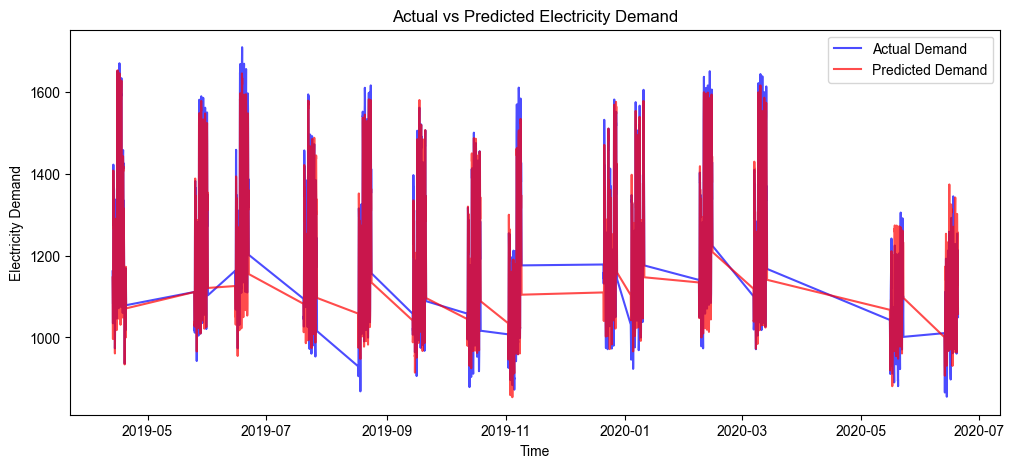

In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import mean_absolute_error, mean_squared_error

## 실제값과 예측값 비교

plt.figure(figsize=(12, 5))
plt.plot(df_test_all["datetime"], y_test, label="Actual Demand", color="blue", alpha=0.7)
plt.plot(df_test_all["datetime"], y_pred, label="Predicted Demand", color="red", alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Electricity Demand")
plt.title("Actual vs Predicted Electricity Demand")
plt.legend()
plt.xticks()
plt.show()

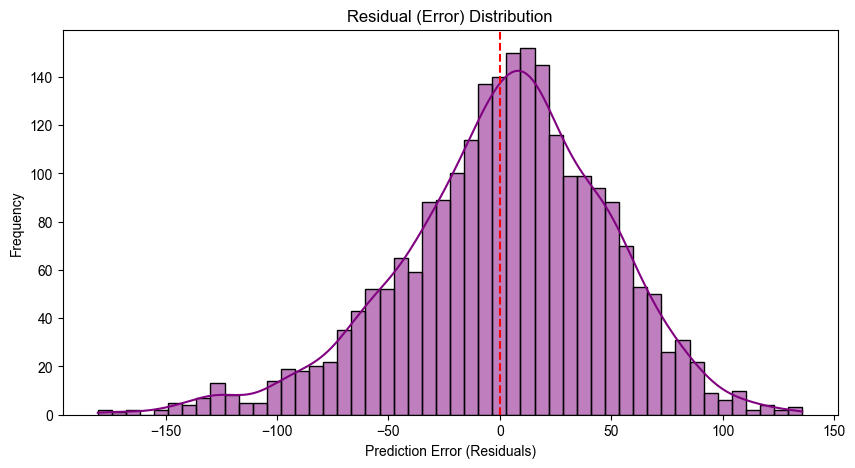

In [102]:
## 잔차 분석 (오차 히스토그램)

residuals = y_test - y_pred

plt.figure(figsize=(10, 5))
sns.histplot(residuals, bins=50, kde=True, color="purple")
plt.axvline(0, color='red', linestyle="--")
plt.xlabel("Prediction Error (Residuals)")
plt.ylabel("Frequency")
plt.title("Residual (Error) Distribution")
plt.show()


/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_11684/494446639.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="coolwarm")


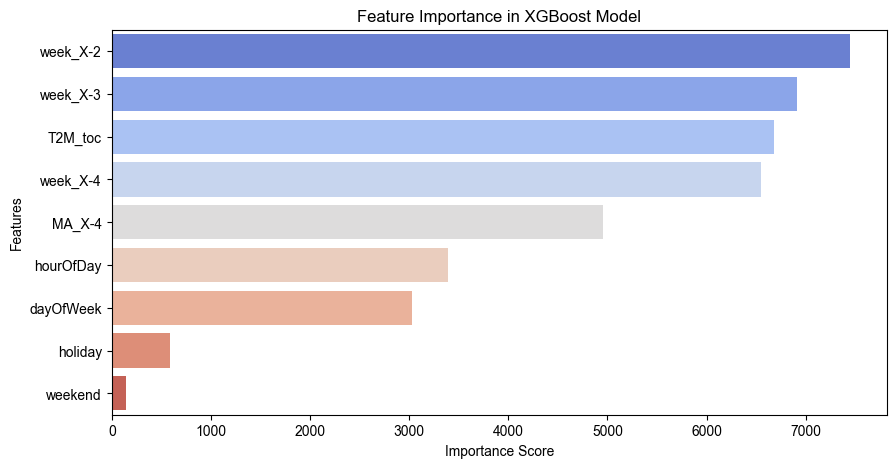

In [103]:
## 변수 중요도

importance = model.get_score(importance_type="weight")
importance_df = pd.DataFrame(list(importance.items()), columns=["Feature", "Importance"])
importance_df = importance_df.sort_values(by="Importance", ascending=False)

plt.figure(figsize=(10, 5))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="coolwarm")
plt.xlabel("Importance Score")
plt.ylabel("Features")
plt.title("Feature Importance in XGBoost Model")
plt.show()


/var/folders/89/s3dvx5n14_335n4x0tt5mbvw0000gn/T/ipykernel_11684/3288945806.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df_test_all["hourOfDay"], y=df_test_all["error"], palette="viridis")


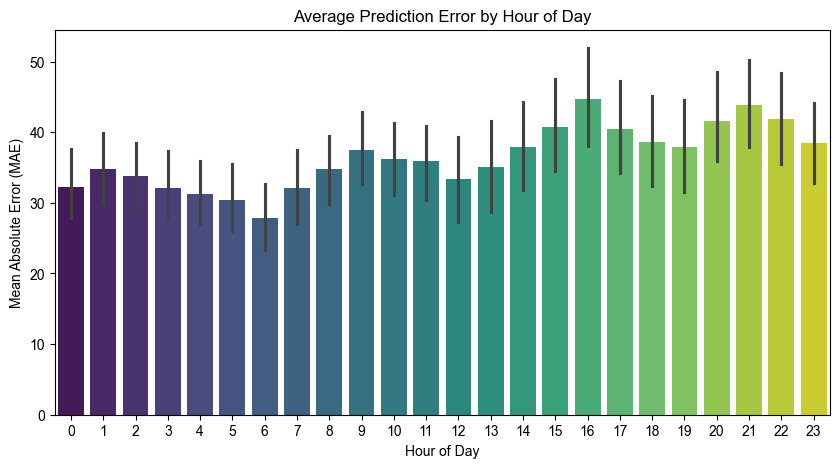

In [104]:
## 시간대별 평균 오차 분석

df_test_all["error"] = abs(y_test - y_pred)

plt.figure(figsize=(10, 5))
sns.barplot(x=df_test_all["hourOfDay"], y=df_test_all["error"], palette="viridis")
plt.xlabel("Hour of Day")
plt.ylabel("Mean Absolute Error (MAE)")
plt.title("Average Prediction Error by Hour of Day")
plt.show()
